In [203]:
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
import matplotlib

In [204]:
print("OpenCV version:", cv2.__version__)
print("imutils version:", imutils.__version__)
print(np.__version__)
print(matplotlib.__version__)

OpenCV version: 4.10.0
imutils version: 0.5.4
2.1.3
3.10.0


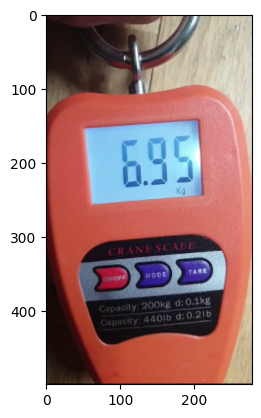

In [205]:
vidcap = cv2.VideoCapture("new_dyn.mp4")
totalFrames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
randomFrameNumber = random.randint(0, int(totalFrames))
vidcap.set(cv2.CAP_PROP_POS_FRAMES, randomFrameNumber)
success, image = vidcap.read()
if success:
    img = imutils.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), height=500)
plt.imshow(img)

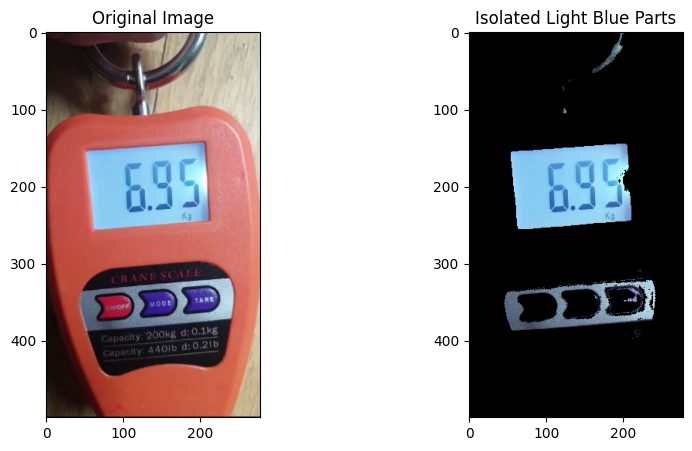

In [206]:
# Convert the image to HSV color space
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

# Define the range for light blue color in HSV
lower_blue = np.array([90, 50, 50])
upper_blue = np.array([120, 255, 255])

# Create a mask for the light blue color
mask = cv2.inRange(hsv, lower_blue, upper_blue)

# Apply the mask to the original image
isolated_blue = cv2.bitwise_and(img, img, mask=mask)

# Show the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(isolated_blue)
plt.title("Isolated Light Blue Parts")
plt.show()

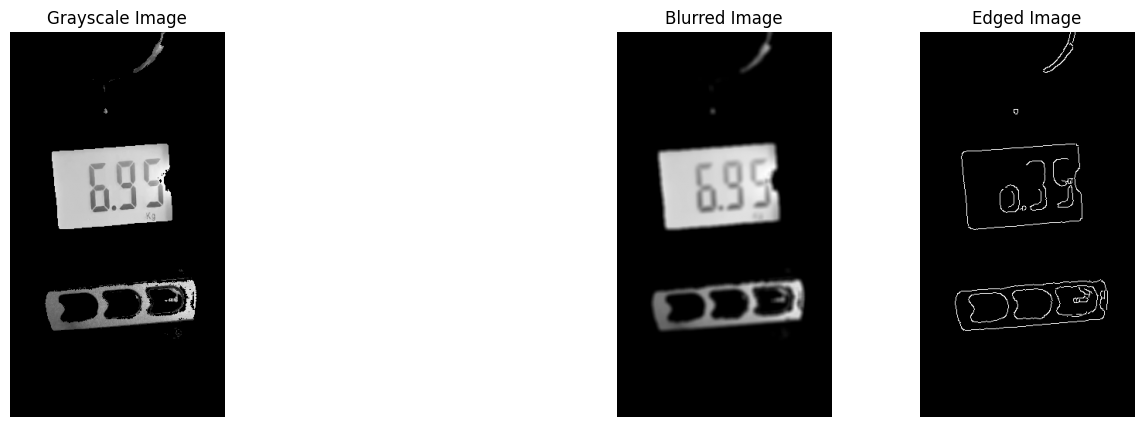

In [207]:
gray = cv2.cvtColor(isolated_blue, cv2.COLOR_RGB2GRAY)
# eq = cv2.equalizeHist(gray)
blurred = cv2.GaussianBlur(gray, (7,7), 3)
edged = cv2.Canny(blurred, 50, 150, 255)

fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].imshow(gray, cmap='gray')
axs[0].set_title('Grayscale Image')
# axs[1].imshow(eq, cmap='gray')
# axs[1].set_title('Equalized Image')
axs[2].imshow(blurred, cmap='gray')
axs[2].set_title('Blurred Image')
axs[3].imshow(edged, cmap='gray')
axs[3].set_title('Edged Image')
for ax in axs:
    ax.axis('off')
plt.show()
# plt.imshow(edged)

Area of the rectangle: 15558.806994358543


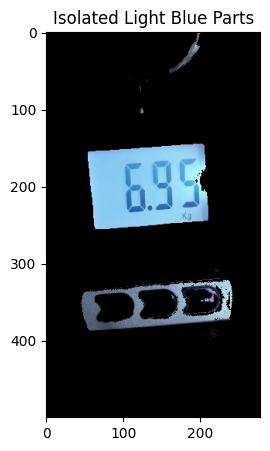

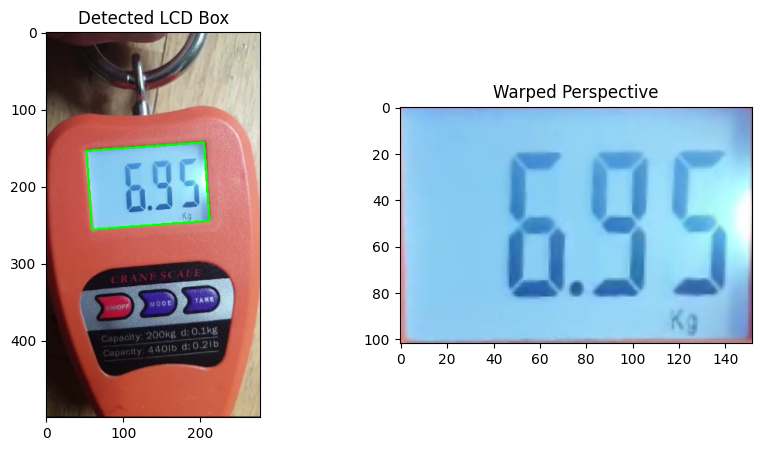

In [208]:
# Convert image to grayscale
gray = cv2.cvtColor(isolated_blue, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blurred, 50, 150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# draw contours on image
contour_img = cv2.drawContours(isolated_blue.copy(), contours, -1, (0, 255, 0), 2)

# Show the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(isolated_blue)
plt.title("Isolated Light Blue Parts")


# Take the contour with the largest area
c = max(contours, key=cv2.contourArea)

# Get the bounding box
rect = cv2.minAreaRect(c)  # Get the rotated bounding box
box = cv2.boxPoints(rect)  # Convert to 4 corner points
box = np.array(box, dtype="float32")  # Ensure correct data type

# Calculate the area of the rectangle
area = rect[1][0] * rect[1][1]
print("Area of the rectangle:", area)

# Order the points correctly
def order_points(pts):
    """ Sorts points into (top-left, top-right, bottom-right, bottom-left) order """
    rect = np.zeros((4, 2), dtype="float32")

    # Sum of coordinates (top-left has the smallest sum, bottom-right has the largest)
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # Top-left
    rect[2] = pts[np.argmax(s)]  # Bottom-right

    # Difference of coordinates (top-right has the smallest difference, bottom-left has the largest)
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # Top-right
    rect[3] = pts[np.argmax(diff)]  # Bottom-left

    return rect

ordered_box = order_points(box)

# Compute the new width and height of the transformed image
width = int(max(np.linalg.norm(ordered_box[0] - ordered_box[1]), np.linalg.norm(ordered_box[2] - ordered_box[3])))
height = int(max(np.linalg.norm(ordered_box[0] - ordered_box[3]), np.linalg.norm(ordered_box[1] - ordered_box[2])))

# Destination points for the perspective transform
dst = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype="float32")

# Compute the perspective transform matrix
M = cv2.getPerspectiveTransform(ordered_box, dst)

# Warp the image
warped = cv2.warpPerspective(img, M, (width, height))

# Show the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.drawContours(img.copy(), [box.astype(int)], -1, (0, 255, 0), 2))
plt.title("Detected LCD Box")

plt.subplot(1, 2, 2)
plt.imshow(warped, cmap="gray")
plt.title("Warped Perspective")
plt.show()